### Phase-based encoding in pairwise neural interactions

In [1]:
import os

In [2]:
import sys

sys.path.insert(1, os.path.join("/", *os.getcwd().split("/")[:-1]))

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency.tfr import tfr_array_morlet, tfr_array_multitaper
from tqdm import tqdm

from src.models import simulate_kuramoto

In [49]:
dt = 0.001  # Integration time-step
fs = 1 / dt
f = 40  # Natural frequency
beta = 3.5  # Noise variance
A = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]]).T
ntrials = 500
time = np.arange(-0.5, 1, 1/fs)  # Time array
T = time.shape[0]

In [50]:
s = 8 / (2 * np.pi * f)

time_start = 0
time_end = 0.4
timestim = time[(time > time_start) & (time < time_end)] - (time_end - time_start) / 2
ind = np.where((time > time_start) & (time < time_end))[0]
gaussian = np.exp(-(timestim**2) / (2 * s**2))
coupling = np.zeros_like(time)
coupling[ind] = gaussian

# Coupling strength array (linearly spaced from 1 to 100)
CS = np.linspace(1, 100, ntrials)

In [51]:
time

array([-0.5  , -0.499, -0.498, ...,  0.997,  0.998,  0.999])

In [52]:
data = []
for trial in tqdm(range(ntrials)):
    data += [
        simulate_kuramoto(
            10 * A,
            coupling * CS[trial],
            f,
            fs,
            beta,
            T,
            seed=trial * 32,
            decim=1
        )
    ]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.89it/s]


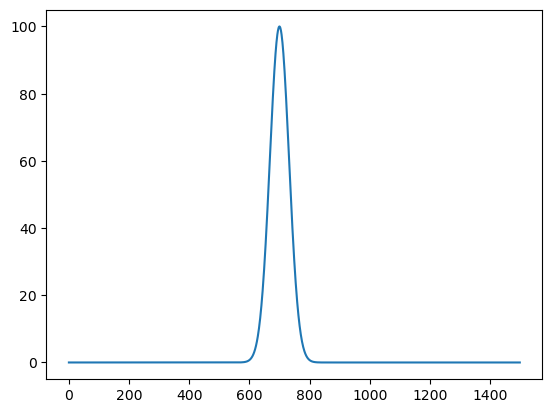

In [16]:
plt.plot( coupling * CS[trial] )

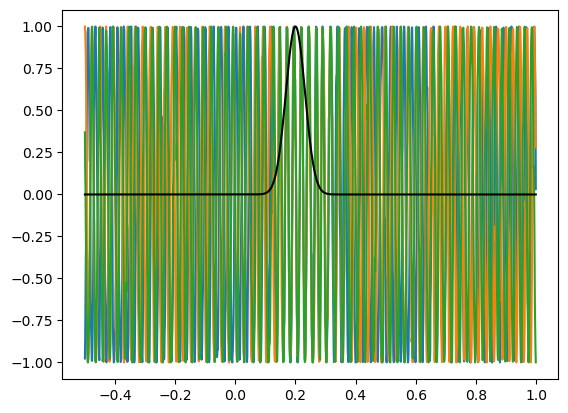

In [17]:
plt.plot(time[::1], data[-1].real.T)
plt.plot(time, coupling, "k")

In [18]:
h = scipy.signal.hilbert(np.stack(data).real, axis=2)

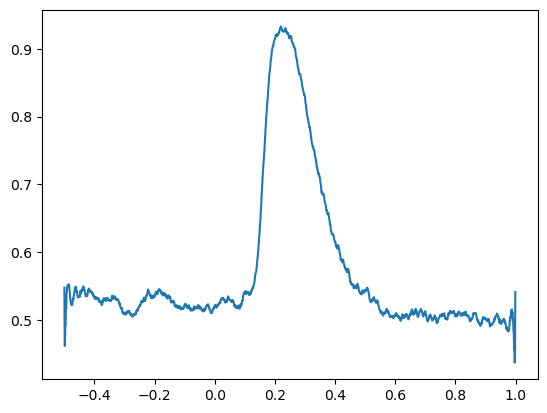

In [20]:
plt.plot(time[::1], np.abs(h.mean(1)).mean(0))

In [21]:
600 /.05

12000.0

In [30]:
freqs = np.linspace(0.1, 80, 50)
W = tfr_array_morlet(
    data,
    fs / 1,
    freqs,
    n_cycles=freqs / 2,
    decim=1,
    output="complex",
    verbose=None,
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s finished


In [31]:
Sxy = (W[:, 0] * np.conj(W[:, 1])).mean(0)
Sxx = (W[:, 0] * np.conj(W[:, 0])).mean(0)
Syy = (W[:, 1] * np.conj(W[:, 1])).mean(0)

coh = np.abs(Sxy) ** 2 / (Sxx * Syy)

Text(0, 0.5, 'Frequency [Hz]')

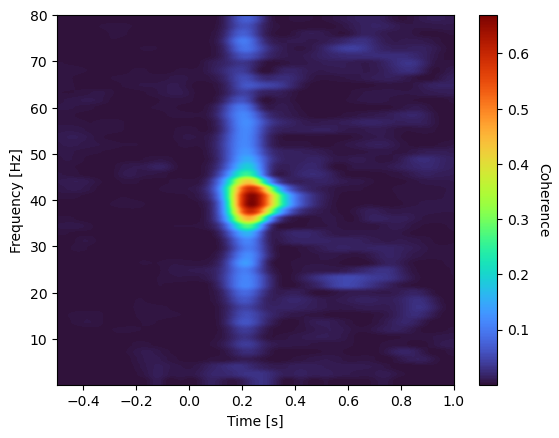

In [43]:
plt.imshow(
    coh.real,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    extent=[-0.5, 1, 0.1, 80],
)
cbar = plt.colorbar()
cbar.set_label("Coherence", rotation=270, labelpad=15)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")

In [33]:
mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))

In [34]:
z = W[:, 0] * np.conj(W[:, 2])

dphi = jnp.stack((z.real, z.imag))

labels = np.tile(
    np.expand_dims(np.linspace(0, 100, ntrials), (1, 2)), (z.shape[1], z.shape[2])
)

mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))

In [46]:
MI_PHI = mi_fcn_time_frequency(z.real[None], labels[None], False, True)

Text(0, 0.5, 'Frequency [Hz]')

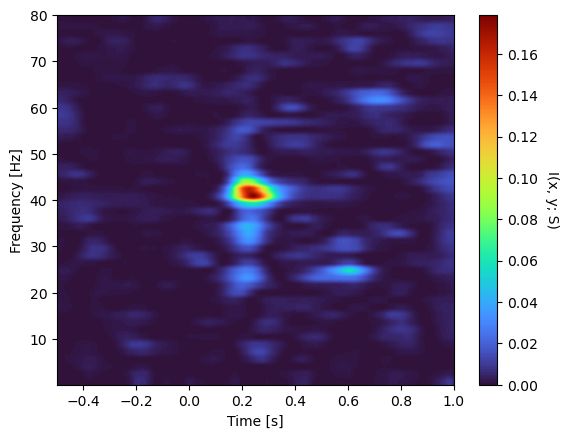

In [48]:
plt.imshow(
    MI_PHI,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    extent=[-0.5, 1, 0.1, 80],
)
cbar = plt.colorbar()
cbar.set_label(r"I(x, y; S)", rotation=270, labelpad=15)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")

In [ ]:
901 * 0.05 / 600

In [ ]:
scipy.io.loadmat("kuramoto_matlab.mat")["data"].transpose(1, 0, 2)[:, :2].shape

In [ ]:
data2 = scipy.io.loadmat("kuramoto_matlab.mat")["data"].transpose(1, 0, 2)[:, [0, 2]]

In [ ]:
plt.plot(data2[-1].T)

In [ ]:
h = scipy.signal.hilbert(np.stack(data2).real, axis=2)
plt.plot(np.abs(h.mean(1)).mean(0))

In [ ]:
freqs = np.linspace(0.1, 80, 50)
W = tfr_array_morlet(
    data2,
    600,
    freqs,
    n_cycles=freqs / 7,
    decim=10,
    output="complex",
    verbose=None,
)

Sxy = (W[:, 0] * np.conj(W[:, 1])).mean(0)
Sxx = (W[:, 0] * np.conj(W[:, 0])).mean(0)
Syy = (W[:, 1] * np.conj(W[:, 1])).mean(0)

coh = np.abs(Sxy) ** 2 / (Sxx * Syy)

plt.imshow(
    coh.real,
    aspect="auto",
    origin="lower",
    cmap="turbo",
)
plt.colorbar()

In [ ]:
z = W[:, 0] * np.conj(W[:, 1])

dphi = jnp.stack((z.real, z.imag))

labels = np.tile(
    np.expand_dims(np.linspace(0, 100, 500), (1, 2)), (z.shape[1], z.shape[2])
)

mi_fcn = get_mi("gc")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))
mi_fcn_time_frequency = jax.vmap(mi_fcn_time, in_axes=(2, 2, None, None))

MI_PHI = mi_fcn_time_frequency(z.real[None], labels[None], False, True)

In [ ]:
plt.imshow(MI_PHI, aspect="auto", origin="lower", cmap="turbo")
plt.colorbar()

In [ ]:
data2.shape

In [ ]:
901 / 600

In [ ]:
import numpy as np


def kuramoto_delays_run_timevar(C, f, fs, icoup, K, npoints):
    """
    Simulates the Kuramoto model with time delays.

    Parameters:
        C (ndarray): Connectivity matrix (NxN)
        D (ndarray): Distance matrix (NxN)
        f (float): Natural frequency (Hz)
        fs (float): Sampling frequency (Hz)
        icoup (array): Coupling scaling values per time step (length = npoints)
        K (float): Global coupling constant
        MD (float): Mean delay in seconds
        npoints (int): Number of simulation time points

    Returns:
        TS (ndarray): Simulated time series (NxT)
        Phases (ndarray): Phase time series (NxT)
    """
    dt = 0.05 / fs  # Integration time step
    noise = 3.5
    N = C.shape[0]
    Omegas = 2 * np.pi * f * np.ones(N) * dt  # Natural frequencies
    kC = K * C * dt  # Coupling matrix scaled
    dsig = np.sqrt(dt) * noise  # Scaled noise

    # Initialize phase history
    Phases_History = (
        2 * np.pi * np.random.rand(N, 1) + Omegas[:, None] * np.arange(1, 2)
    ) % (2 * np.pi)
    Phases = np.zeros((N, npoints))
    sumz = np.zeros(N)

    # print(f"Now running for K={K}, mean Delay = {MD * 1e3:.2f} ms")

    for t in range(npoints):
        Phase_Now = Phases_History[:, -1]  # Current phase
        for n in range(N):
            sumzn = 0
            for p in range(N):
                if kC[n, p] != 0:
                    sumzn += icoup[t] * kC[n, p] * np.sin(Phase_Now[p] - Phase_Now[n])
            sumz[n] = sumzn

        # Update last history entry
        Phases_History[:, -1] = Phase_Now + Omegas + sumz + dsig * np.random.randn(N)

        # Save current phase
        Phases[:, t] = Phases_History[:, -1]

    # Convert phases to time series using sine and FFT/iFFT
    Fourier = np.fft.fft(np.sin(Phases), axis=1)
    TS = np.real(np.fft.ifft(Fourier, axis=1))

    return TS  # For Kuramoto phases_history is cast to float
    # Randomly initialize phases and keeps it only up to max delay
    phases_History = (
        2 * np.pi * np.random.rand(N, 1) + omegas[:, None] * np.arange(1, 2)
    ) % (2 * np.pi)

In [ ]:
data += [
    kuramoto_delays_run_timevar(A, 40, 600, coupling * Amplitudes[trial], 10, T)
    for trial in tqdm(range(ntrials))
]

In [ ]:
plt.plot(time[::1], data[-1].real.T)

plt.xlim(0, 0.1)

In [ ]:
freqs = np.linspace(0.1, 80, 50)
W = tfr_array_morlet(
    data,
    600,
    freqs,
    n_cycles=freqs / 7,
    decim=10,
    output="complex",
    verbose=None,
)

In [ ]:
Sxy = (W[:, 0] * np.conj(W[:, 1])).mean(0)
Sxx = (W[:, 0] * np.conj(W[:, 0])).mean(0)
Syy = (W[:, 1] * np.conj(W[:, 1])).mean(0)

coh = np.abs(Sxy) ** 2 / (Sxx * Syy)

In [ ]:
plt.imshow(
    coh.real,
    aspect="auto",
    origin="lower",
    cmap="turbo",
    extent=[-1, 2, 0.1, 80],
)
plt.colorbar()